# Real data experiments

We perform real data experiments on the Imagenet and MSCOCO datasets, for controlling risk metrics of various classifiers. These experiments have identical setup to the experiments in [Distribution-Free, Risk-Controlling Prediction Sets](https://arxiv.org/abs/2101.02703).

## Imagenet

Imagenet examples consist of an image $x \in \mathcal{X}$ that is paired with a single correct class $y \in \mathcal{Y}$.

Our loss is defined as follows for a label set $S$, and the corresponding true label $y$ is as follows:

$$ L(y, S) := L_y \mathbf{1}_{\left\{y \not\in S\right\}},$$

where $L_y \in \mathbb{R}^+$ denotes a user chosen penalty weight specifically for class $y$.

We can use a probabilistic classifier $\mathbf{p}: \mathcal{X} \mapsto \Delta^{|\mathcal{Y}|}$ to produce a probability distribution $\mathbf{p}(x)$ for each image $x$. Then, we can define the corresponding label set as follows:
$$S(x) := \left\{y \in \mathcal{Y}: \mathbf{p}(x)_y \geq \beta \right\},$$
where $\beta \in [0, 1]$ is the cutoff threshold for which labels to include in the label set.

We directly work with $\mathbf{p}(x)$ generated using a ResNet512 classifier trained on Imagenet.

In [1]:
def load_data(data_dir):
    import load_data
    return load_data.load_imagenet_torch_preds(data_dir)

In [2]:
data_dir = 'data/imagenet_no_T'
scores, labels = load_data(data_dir)
scores.shape, labels.shape

((50000, 1000), (50000,))

In [92]:
class WeightedCoverage(object):
    def __init__(self, w=None):
        import numpy as np
        import torch
    
        super().__init__()
        self.w = w if w is not None else np.ones(1000)
        self.torch_w = torch.Tensor(self.w)

    def __call__(self, PXY, betas, is_torch=False):
        import numpy as np
        (P, _), Y = PXY
        if is_torch:
            return (1. - (betas <= P)[np.arange(P.shape[0]), Y].float()) * self.torch_w[Y]
        else:
            return (1. - (betas <= P)[np.arange(P.shape[0]), Y]) * self.w[Y]
        # return (np.argmax(P, axis=-1) == Y)

    def sample(self):
        import torch
        
        p = torch.rand(1)
        y = torch.bernoulli(p)
        return p, y

        
class TopBetaCoverage(object):
    
    def __init__(self, w=None, torch_w=None):
        import torch

        import numpy as np
    
        super().__init__()
        if torch_w is None:
            self.w = w if w is not None else np.ones(1000)
            self.torch_w = torch.Tensor(self.w)
        else:
            self.torch_w = torch_w
            self.w = torch_w.detach().numpy()
    
    def _coverage_mask(self, idx_arr, top_idx):
        """Get mark array that indicates the labeled that are covered
        :param w_P: n x classes tensor that's label cost times predicted prob. for label
        :param idx_arr: n x classes tensor that class indices sorted by highest to lowest predicted prob.
        :param top_idx: n len tensor of number of indices covered under a choice of beta
        """
        import torch
        mask = torch.zeros(idx_arr.shape).bool()
        row_indices = torch.cat([torch.full((top_idx[i].item() + 1,), i) for i in range(len(top_idx))])
        col_indices = torch.cat([idx_arr[i, :(top_idx[i] + 1)] for i in range(len(top_idx))])
        mask[row_indices, col_indices] = True
        return mask
    
    def beta_coverage_set(self, P, betas):
        import torch
        w_P = P * self.torch_w.reshape(1, -1)
        sort_arr, idx_arr = torch.sort(w_P, descending=True, dim=-1, stable=True)
        sums_arr = torch.cumsum(sort_arr, dim=-1)
        top_idx = torch.argmax((sums_arr >= betas).int(), dim=-1)
        
        # if all sums are below beta, set to last possible index (i.e., include all labels)
        sum_small_idxs = torch.all(sums_arr < betas, dim=-1)
        top_idx[sum_small_idxs] = self.torch_w.shape[0] - 1

        return self._coverage_mask(idx_arr, top_idx)

    def _compute_loss(self, P, Y, betas):
        import torch
        w_P = P * self.torch_w.reshape(1, -1)
        sort_arr, idx_arr = torch.sort(w_P, descending=True, dim=-1, stable=True)
        sums_arr = torch.cumsum(sort_arr, dim=-1)
        top_idx = torch.argmax((sums_arr >= betas).int(), dim=-1)
        
        # if all sums are below beta, set to last possible index (i.e., include all labels)
        sum_small_idxs = torch.all(sums_arr < betas, dim=-1)
        top_idx[sum_small_idxs] = self.torch_w.shape[0] - 1
        top_idx = top_idx.reshape(-1, 1)
        
        label_top_idx = torch.argmax((idx_arr == Y.reshape(-1, 1)).int(), dim=-1).reshape(-1, 1)
        miscover_arr = (label_top_idx > top_idx).float()
        assert torch.all(Y <= 1000), Y
        return miscover_arr * self.torch_w[Y].reshape(-1)
    
    def __call__(self, PXY, betas, is_torch=False, betas_is_torch=False):
        """Either beta can be single or multipel rows (i.e., single beta)"""
        
        import torch
        (P, _), Y = PXY
        
        betas = (betas if betas_is_torch else torch.Tensor([betas])).reshape(-1, 1)
        
        # Either a batch of P or a batch of betas, but not both
        assert len(P.shape) == 1 or (P.shape[0] == 1) or betas.shape[0] == 1, (P.shape, betas.shape)
        if len(P.shape) == 1:
            P = P.reshape(1, -1)
        
        if is_torch:
            res = self._compute_loss(P, Y, betas)
        else:
            res = self._compute_loss(torch.Tensor(P), torch.Tensor([Y]).reshape(-1).int(), betas).numpy()
            
        if betas.shape[0] != 1:
            return res.reshape(-1)
        else:
            return res
        # return (np.argmax(P, axis=-1) == Y)

    def sample(self):
        import torch
        
        p = torch.rand(1)
        y = torch.bernoulli(p)
        return p, y

[0.00 0.25 0.50 0.75 1.00]


Compute average risk:   0%|          | 0/5 [00:00<?, ?it/s]

[0.21685785, 0.21305752, 0.18489791, 0.124759324, 6e-05]


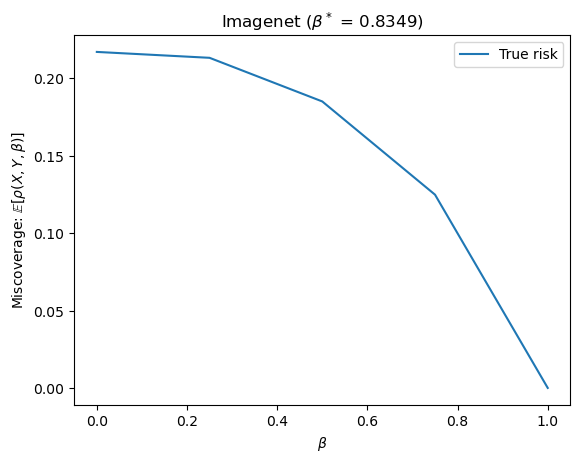

In [101]:
def predicted_risk(P, w, beta):
    import torch
    
    P, w = torch.Tensor(P), torch.Tensor(w)
    w_P = P * w.reshape(1, -1)
    w_P_sq = torch.square(P) * w.reshape(1, -1)
    sort_arr, idx_arr = torch.sort(w_P, descending=True, dim=-1, stable=True)


    sums_arr = torch.cumsum(sort_arr, dim=-1)
    top_idx = torch.argmax((sums_arr >= beta).int(), dim=-1)
    # if all sums are below beta, set to last possible index (i.e., include all labels)
    sum_small_idxs = torch.all(sums_arr < beta, dim=-1)
    top_idx[sum_small_idxs] = w.shape[0] - 1
        
    exc_sums = []
    for i in range(P.shape[0]):
        if top_idx[i] == w.shape[0] - 1:
            exc_sums.append(0)
        else:
            exc_idxs = idx_arr[i, (top_idx[i] + 1):]
            exc_sums.append(((w[exc_idxs] ** 2) * P[i, :][exc_idxs]).sum())
    return torch.Tensor(exc_sums).numpy()


def plot_imagenet_true_rho(scores, labels):
    import matplotlib.pyplot as plt
    import numpy as np
    from tqdm.notebook import tqdm
    import scipy
    
    
    rho = TopBetaCoverage()
    
    betas = np.linspace(0.0, 1., 5)
    print(betas)
    # predicted_risks = [np.mean(predicted_risk(scores, np.ones(1000), beta)) for beta in betas]
    # risks = [np.mean([rho(((scores[i].reshape(1, -1), None), [labels[i]]), beta) for i in range(len(scores))]) for beta in tqdm(betas, 'Compute average risk')]
    risks = [np.mean(rho(((scores, None), labels), beta)) for beta in tqdm(betas, 'Compute average risk')]
    
    print(risks)
    # print(other_risks)
    
    theta = 0.1
    def func(beta):
        return np.mean(rho(((scores, None), labels), beta)) - theta
    res = scipy.optimize.root_scalar(func, method='brentq', rtol=1e-4, bracket=(0, 1))
    assert res.converged, "Didn't converge"
    
    fig, ax = plt.figure(), plt.gca()
    ax.set_title(f"Imagenet ($\\beta^*$ = {res.root:.4f})")
    
    ax.plot(betas, risks, label='True risk'), ax.set_xlabel('$\\beta$'), ax.set_ylabel('Miscoverage: $\\mathbb{E}[\\rho(X, Y, \\beta)]$')
    # ax.plot(betas, predicted_risks, label='Predicted risk')
    ax.legend()
    
    # fig, ax = plt.figure(), plt.gca()
    # ax.hist([np.sum(row[row > 0] * np.log(1 / row[row > 0])) for row in scores]), ax.set_xlabel('$H(\mathbf{p}(X))$'), ax.set_ylabel('Frequency')
    # ax.set_title('Imagenet Entropies')
plot_imagenet_true_rho(scores, labels)

In [94]:
def digitize(p, knots):
    import torch
    rv = torch.zeros(len(knots))
    if p >= knots[-1]:
        rv[-1] = 1.
    else:
        z = torch.bucketize(p, knots)
        vlow, vhigh = knots[z-1], knots[z]
        frac = (p - vlow) / (vhigh - vlow)
        rv[z - 1], rv[z] = 1 - frac, frac
    return rv



def featurize(P, w, beta, knots_type='uneven'):
    import torch
    
    if knots_type == 'even':
        beta_knots = torch.linspace(0, 1, 5)
        est_loss_knots = torch.linspace(0, 1, 10)
    else:
        beta_knots = torch.cat([torch.zeros(1), torch.linspace(0.9, 1, 4)])
        est_loss_knots = torch.linspace(0, 1, 10)
    
    tbc = TopBetaCoverage(torch_w=w)
    w_P_sq = (P ** 2) * w.reshape(1, -1)
    
    exc_sums = (w_P_sq * (~(tbc.beta_coverage_set(P, torch.Tensor([beta])))).int()).sum(dim=-1)
    beta_vec = torch.cat([digitize(beta, beta_knots), torch.ones(1)])
    scale_factor = 1 if torch.all(beta_knots > beta) else (1 - beta_knots[torch.argmin((beta_knots <= beta).int())])
    
    rvs = []
    for i in range(len(exc_sums)):
        exc_sum_vec = digitize(exc_sums[i], est_loss_knots * scale_factor)
        rvs.append(torch.outer(beta_vec, exc_sum_vec).reshape(1, -1))
    res = torch.concatenate(rvs)
    return res

n    	 L    	 bet       	 beta      	 p                                                           	 Q(p)                                                        	 cons      	 dual      	


Running samples:   0%|          | 0/50000 [00:00<?, ?it/s]

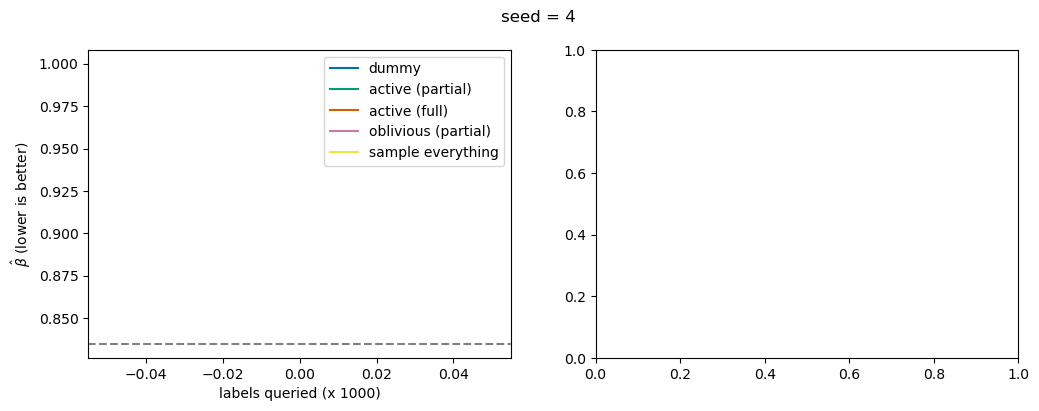

In [131]:
%matplotlib inline
def test_once(seed, dipslay_step=1000):
    from itertools import product
    from IwUpperMartingale import FullIwUpperMartingale, PartialIwUpperMartingale, FullyObservedUpperMartingale, ShiftedIwUpperMartingale, BaseMartingale
    from OnlineMinimax import OnlineMinimax, WindowedBeTheLeader
    from LogisticRegression import MultilabelRegressor
    import numpy as np
    import torch
    from tqdm.notebook import tqdm
    import multiprocess as mp
    
    class DummyMartingale(BaseMartingale):
        """Class that always outputs a singular beta"""
        def __init__(self, *, theta, rho, q_min, init_beta, xi_fn,  **kwargs):
            from collections import defaultdict
            from math import log
            import numpy as np

            super().__init__()

            self._rho = rho
            self._theta = theta
            self._q_min = q_min
            self._xi_fn = xi_fn
            self._betas = np.array([init_beta])

            # Column 0: sum logwealth = sum log1p(curlam * xi)
            # Column 1: sum xi
            # Column 2: sum xi**2
            self._stats = np.zeros((1, 3))

            self._curbetaindex = 0     # smallest beta that is proven safe
            self._curlam = 0
            
            self._maxlam = (1/2) * (1 / abs(self.ximin))

        def xi(self, x, q, l, betas):
            if self._xi_fn == 'full':
                return (l / q) * (self._theta - self._rho(x, betas))
            else:
                return self._theta - ((l / q) * self._rho(x, betas))
        
        @property
        def ximin(self):
            if self._xi_fn == 'full':
                return (self._theta - 1) / self._q_min
            else:
                return self._theta - (1 / self.q_min)
        @property
        def curlam(self):
            return self._curlam

        @property
        def curbeta(self):
            return ( self._betas[self._curbetaindex],
                     self._betas[max(0, self._curbetaindex-1)],
                     self._stats[max(0, self._curbetaindex-1), 0],
                   )

        def addobs(self, x, q, l):
            import numpy as np

            xibetas = np.array(self.xi(x, q, l, self._betas)).reshape(-1)
            self._stats[:,0] += np.log1p(self._curlam * xibetas)
            self._stats[:,1] += xibetas
            self._stats[:,2] += xibetas**2
        
            ftlnum = self._stats[self._curbetaindex, 1]
            ftldenom = self._stats[self._curbetaindex, 1] + self._stats[self._curbetaindex - 1, 2]
            self._curlam = 0 if ftlnum <= 0 else min(self._maxlam, ftlnum / ftldenom)
    
            
    if True:
        torch.manual_seed(seed)
        np.set_printoptions(2, floatmode='fixed')

        wc_rho = TopBetaCoverage()
        rho = lambda x, beta: wc_rho(x, beta, is_torch=True)
        theta = 0.1
        q_min = 0.1
        target_rate = 0.3
        
        
        
        # feature_ct = (len(beta_knots) + 1) * len(est_loss_knots)
        feature_ct = 60
        def makeMinimax(policy, lr, q_min, target_rate, iwmart):
            from player import LabellingPolicyPrimalPlayer
            opt = torch.optim.Adam(policy.parameters(), lr=lr)
            sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:1) # (1+t/1000)**(-0.5))

            primal_player = LabellingPolicyPrimalPlayer(policy=policy, 
                                                        q_min=q_min,
                                                        target_rate=target_rate,
                                                        theta=theta,
                                                        rho=rho,
                                                        opt=opt,
                                                        sched=sched,
                                                        iwmart=iwmart)
            # anything bigger than (1 - Log[2]) should be good enough for max_dual
            dual_player = WindowedBeTheLeader(max_dual=1 - np.log(2), window_size=256)
            return OnlineMinimax(primal_player=primal_player, dual_player=dual_player)        
        
        
        partial_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True),
                                                lr=5e-3,
                                                q_min=q_min, 
                                                target_rate=target_rate,
                                                iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                               )
        shifted_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True),
                                         lr=5e-3,
                                         q_min=q_min, 
                                         target_rate=target_rate,
                                         iwmart=ShiftedIwUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05),
                                        )
        
        full_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True),
                                      lr=5e-3,
                                      q_min=q_min, 
                                      target_rate=target_rate,
                                      iwmart=FullIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        const_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=False), 
                                       lr=0,
                                       q_min=q_min, 
                                       target_rate=target_rate,
                                       iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        fobv_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=False), 
                                      lr=0,
                                      q_min=1, 
                                      target_rate=2,
                                      iwmart=FullyObservedUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05))
        
        dummy_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True), 
                                      lr=5e-3,
                                      q_min=q_min, 
                                      target_rate=target_rate,
                                      iwmart=DummyMartingale(rho=rho, theta=theta, q_min=q_min, init_beta=0.9, xi_fn='full'))

        partialsumls, partialbetas = [0], [partial_minimax._primal_player._iwmart.curbeta[0]]
        fullsumls, fullbetas = [0], [full_minimax._primal_player._iwmart.curbeta[0]]
        constsumls, constbetas = [0], [const_minimax._primal_player._iwmart.curbeta[0]]
        fobvsumls, fobvbetas = [0], [fobv_minimax._primal_player._iwmart.curbeta[0]]
        dummysumls, dummybetas = [0], [dummy_minimax._primal_player._iwmart.curbeta[0]]
        

    print(f'{"n":5s}\t', f'{"L":5s}\t', f'{"bet":10s}\t', f'{"beta":10s}\t', f'{"p":60s}\t', f'{"Q(p)":60s}\t', f'{"cons":10s}\t', f'{"dual":10s}\t')
    
    randperm = torch.randperm(len(scores))
    rand_scores, rand_labels = torch.Tensor(scores[randperm]), torch.Tensor(labels[randperm]).int()
    
    minimaxes = [dummy_minimax, partial_minimax, full_minimax, const_minimax, fobv_minimax]
    sumlses = [dummysumls, partialsumls, fullsumls, constsumls, fobvsumls]
    betases = [dummybetas, partialbetas, fullbetas, constbetas, fobvbetas]
    names = ['dummy', 'active (partial)', 'active (full)', 'oblivious (partial)', 'sample everything']
    for n in tqdm(range(50000), desc="Running samples"):
    
        p, y = rand_scores[n], rand_labels[n]
        
        fullbeta = full_minimax._primal_player._iwmart.curbeta[0]
        x = featurize(p.reshape(1, -1), torch.ones(1000), fullbeta).reshape(1, -1)
        
        in_data = ((p.reshape(1, -1), x), y.reshape(1, -1))
        
        for minimax, sumls, betas in list(zip(minimaxes, sumlses, betases))[:1]:
            minimax.addobs(in_data)
            beta = minimax._primal_player._iwmart.curbeta[0]
            if beta < betas[-1]:
                sumls.append(minimax._primal_player._suml)
                betas.append(beta)

    with torch.no_grad():
        import matplotlib.pyplot as plt 
        with plt.style.context("seaborn-colorblind"):
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f'seed = {seed}')
            
            step_scale = 1000
            for name, betas, sumls in zip(names, betases, sumlses):
                ax[0].plot(np.array(sumls)/step_scale, betas, label=name)
            ax[0].set_xlabel(f'labels queried (x {step_scale})')
            ax[0].set_ylabel('$\\hat{\\beta}$ (lower is better)')
            ax[0].axhline(.8349, linestyle='dashed', color='gray')
            ax[0].legend()

    return minimaxes

    
def test():
    for seed in range(4, 5):
        res = test_once(seed=seed)
        if seed == 4:
            return res
minimaxes = test()

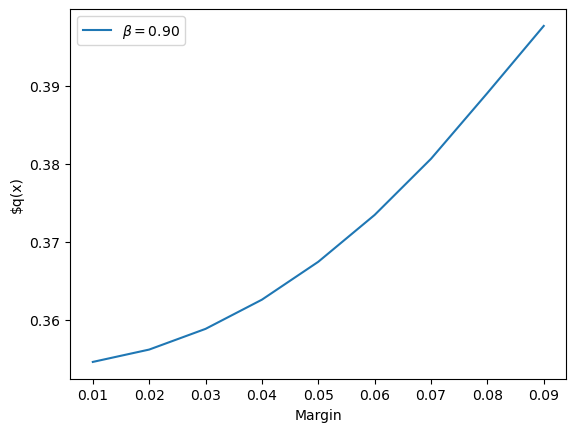

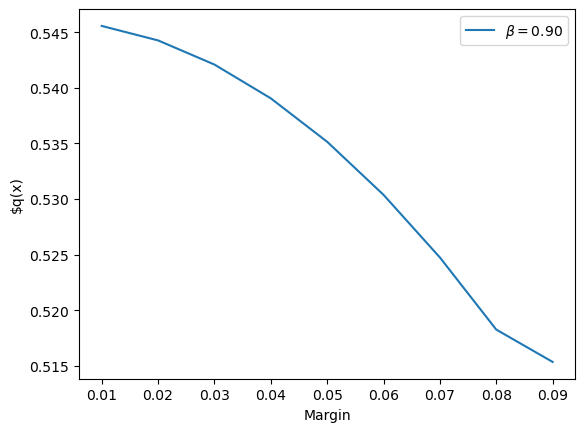

In [132]:
def make_probe_data(test_beta, weights, margin, featurize):
    import torch
    Xs = []
    ps = []
    temp_weights = torch.ones(1000)
    for i in range(len(margin)):
        temp_p = torch.zeros(1000)
        temp_p[0] = test_beta + (1 - margin[i])
        temp_p[1] = margin[i]
        ps.append(temp_p.reshape(1, -1))
        Xs.append(featurize(temp_p.reshape(1, -1), weights, test_beta).reshape(1, -1))

    X = torch.concatenate(Xs)
    p = torch.concatenate(ps)
    return p, X
def probe(minimax, featurize):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    
    betas = np.arange(0.9, 1, 0.01)
    margins = np.arange(0.01, 0.1, 0.01) 
    probe_datas = [make_probe_data(beta, torch.ones(1000), margins, featurize) for beta in betas]
    results = []
    for probe_data in probe_datas:
        (Q, _), cons = minimax._primal_player.predict((probe_data, None))
        results.append(Q.detach().numpy())
    
    
    q_vals = np.array(results)
    """
    fig, ax = plt.figure(), plt.gca()
    
    ax.imshow(q_vals)
    ax.set_xlabel('Margin values'), ax.set_ylabel('Beta values')
    ax.set_xticks(np.arange(len(margins)), labels=[f'{x:.2f}' for x in margins])
    ax.set_yticks(np.arange(len(betas)), labels=[f'{x:.2f}' for x in betas])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(betas)):
        for j in range(len(margins)):
            text = ax.text(j, i, f'{q_vals[i, j]:.2f}',
                           ha="center", va="center", color="w")
    """
    fig, ax = plt.figure(), plt.gca()
    #for i in range(0, len(betas), 1):
    i = 0
    beta, q_val = betas[i], q_vals[i]
    max_margin = 1 - beta
    mask = margins <= max_margin
    ax.plot(margins[mask], q_val[mask], label=f"$\\beta={beta:.2f}$")
    ax.set_xlabel('Margin'), ax.set_ylabel('$q(x)')
    ax.legend()
probe(minimaxes[0], featurize)
probe(minimaxes[2], featurize)
            

## COCO MS

COCOMS dataset is a multilabel classification dataset. Hence, examples consist of an image $x \in \mathcal{X}$ that is paired with a _vector_ of labels $\mathbf{y} \in 2^\mathcal{Y}$.

Our goal is is still to form a label set $S$, but now we are interested in computing the inverse of the recall as our loss:

$$ L(\mathbf{y}, S) := L_y \mathbf{1}_{\left\{y \not\in S\right\}},$$

where $L_y \in \mathbb{R}^+$ denotes a user chosen penalty weight specifically for class $y$.

We can use a probabilistic classifier $\mathbf{p}: \mathcal{X} \mapsto \Delta^{|\mathcal{Y}|}$ to produce a probability distribution $\mathbf{p}(x)$ for each image $x$. Then, we can define the corresponding label set as follows:
$$S(x) := \left\{y \in \mathcal{Y}: \mathbf{p}(x)_y \geq \beta \right\},$$
where $\beta \in [0, 1]$ is the cutoff threshold for which labels to include in the label set.

We directly work with $\mathbf{p}(x)$ generated using a ResNet512 classifier trained on Imagenet.

In [ ]:
coco_data_dir = 'data/coco'
coco_scores, coco_labels = load_data(coco_data_dir)
coco_scores.shape, coco_labels.shape

In [ ]:
class NegRecall(object):
    def __init__(self):
        super().__init__()
        
    def __call__(self, PXY, betas, batch=None):
        import numpy as np
        (P, _), Y = PXY
        if batch:
            recall = np.sum((betas <= P).astype(bool) & Y.astype(bool), axis=1) / np.sum(Y, axis=1)
        else:
            recall = np.sum((betas <= P).astype(bool) & Y.astype(bool)) / np.sum(Y)
        return 1 - recall

    def sample(self):
        import torch
        
        p = torch.rand(1)
        y = torch.bernoulli(p)
        return p, y

In [ ]:
def plot_coco_true_rho():
    import matplotlib.pyplot as plt
    import numpy as np
    
    rho = NegRecall()
    betas = np.power(10, -1 * np.arange(1, 2.5, .01))
    
    risks = [np.mean(rho(((coco_scores, None), coco_labels), beta)) for beta in betas]
    fig, ax = plt.figure(), plt.gca()
    ax.plot(betas, risks), ax.set_xlabel('$\\beta$'), ax.set_ylabel('True neg. recall: $\\mathbb{E}[\\rho(X, Y, \\beta)]$')
    ax.set_xscale('log')
    ax.set_title('COCO-MS')
plot_coco_true_rho()

## Simulations

In [ ]:
def ideal_q_preds(scores, labels):
    import sklearn.linear_model
    from sklearn.linear_model import LogisticRegression as LR
    import torch
    scores, labels = torch.Tensor(scores), torch.Tensor(labels)
    betas = torch.arange(0.1, 0.9, 0.2)
    margins = torch.arange(0.1, 0.9, 0.2)
    X = torch.cat([featurize(scores, torch.ones(1000), beta) for beta in betas]).numpy()
    tot_labels = torch.cat([labels for _ in range(betas)])
        
    model = LR(penalty=None, multi_class='multinomial')
    model.fit(X, tot_labels)
    
    probe_data = torch.cat([make_probe_data(beta, torch.ones(1000), margin, featurize) for beta in betas for margin in margins])
    q_vals = model.predict(probe_data).reshape(-1, len(margins))
        
    fig, ax = plt.figure(), plt.gca()
    for i in range(0, len(betas), 1):
        beta, q_val = betas[i], q_vals[i]
        max_margin = 1 - beta
        mask = margins <= max_margin
        ax.plot(margins[mask], q_val[mask], label=f"$\\beta={beta:.1f}$")
    ax.set_xlabel('Margin'), ax.set_ylabel('$q(x)')
    ax.legend()
ideal_q_preds(scores, labels)